In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from PIL import Image
import random
import os

# Definimos la arquitectura de la red siamesa
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 53 * 53, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

    def forward_one(self, x):
        output = self.cnn(x)
        output = output.flatten(start_dim=1)
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

# Calcular la similitud del coseno entre los vectores de características
def cosine_similarity(vec1, vec2):
    dot_product = torch.sum(vec1 * vec2, dim=1)
    norm1 = torch.norm(vec1, dim=1)
    norm2 = torch.norm(vec2, dim=1)
    cosine_sim = dot_product / (norm1 * norm2)
    return cosine_sim

# Definir el conjunto de datos
class SiameseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name1 = os.path.join(self.root_dir, random.choice(self.image_list))
        img1 = Image.open(img_name1).convert('L')  # Convertir a escala de grises

        if random.random() < 0.5:  # Generar par de imágenes iguales
            img_name2 = img_name1
            label = torch.tensor([1], dtype=torch.float32)
            # Modificamos ligeramente la imagen
            img1 = transforms.functional.adjust_brightness(img1, 1.1)
            img1 = transforms.functional.adjust_contrast(img1, 1.2)
            # Aplicamos una transformación afín
            img1 = transforms.functional.affine(img1, angle=15, translate=(0, 0), scale=1.2, shear=0, interpolation=InterpolationMode.BILINEAR)

        else:  # Generar par de imágenes diferentes
            img_name2 = os.path.join(self.root_dir, random.choice(self.image_list))
            while img_name2 == img_name1:
                img_name2 = os.path.join(self.root_dir, random.choice(self.image_list))
            label = torch.tensor([0], dtype=torch.float32)

        img2 = Image.open(img_name2).convert('L')  # Convertir a escala de grises

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, label

# Transformaciones para preprocesar las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Crear dataset y DataLoader
dataset = SiameseDataset(root_dir='./data/house_rooms/living', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Instanciamos modelo y definimos criterio y optimizador
model = SiameseNetwork()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
epochs = 5
for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        input1, input2, labels = data
        optimizer.zero_grad()
        output1, output2 = model(input1, input2)
        cosine_sim = cosine_similarity(output1, output2)
        # En este momento, cosine_sim es un tensor con valores entre -1 y 1. Necesitamos convertirlo a un tensor con valores entre 0 y 1
        cosine_sim = (cosine_sim + 1) / 2
        loss = criterion(cosine_sim, labels.squeeze())
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, len(dataloader), loss.item()))

print("Entrenamiento completado.")


Epoch [1/10], Step [1/40], Loss: 2.5353
Epoch [2/10], Step [1/40], Loss: 0.6100
Epoch [3/10], Step [1/40], Loss: 0.5017
Epoch [4/10], Step [1/40], Loss: 3.6350
Epoch [5/10], Step [1/40], Loss: 0.7677
Epoch [6/10], Step [1/40], Loss: 0.6397
Epoch [7/10], Step [1/40], Loss: 1.4441
Epoch [8/10], Step [1/40], Loss: 0.6447
Epoch [9/10], Step [1/40], Loss: 1.0153
Epoch [10/10], Step [1/40], Loss: 0.3429
Entrenamiento completado.


In [14]:
# Validamos el modelo con los datos de entrenamiento
correct = 0
total = 0
with torch.no_grad():
    for data in dataloader:
        input1, input2, labels = data
        labels = labels.squeeze()
        output1, output2 = model(input1, input2)
        cosine_sim = cosine_similarity(output1, output2)
        predicted = (predicted + 1) / 2
        predicted = torch.round(cosine_sim)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the {} train images: {}%'.format(total, 100 * correct / total))


Accuracy of the network on the 1273 train images: 70.62058130400628%


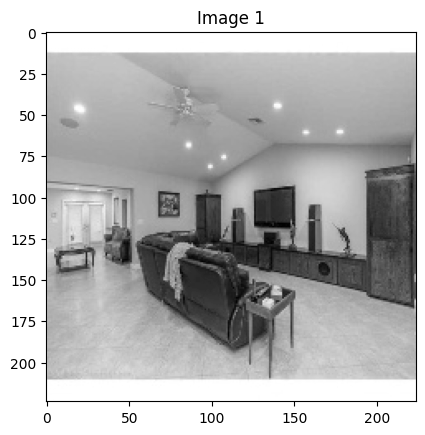

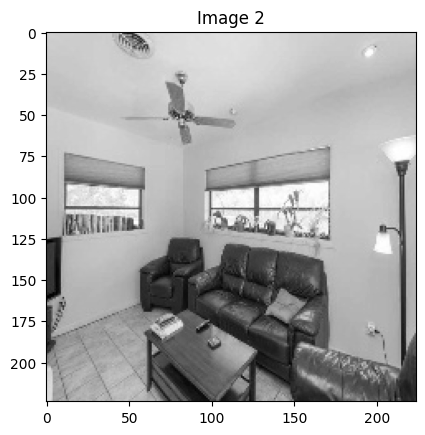

Etiqueta: 0.0


AttributeError: 'tuple' object has no attribute 'squeeze'

In [23]:
dataset = SiameseDataset(root_dir='./data/house_rooms/living', transform=transform)

# Mostramos algunos ejemplos
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img, cmap='gray')
    if title is not None:
        plt.title(title)

# Muestramos un par de imágenes
img1, img2, label = dataset[0]
imshow(img1, title='Image 1')
plt.show()
imshow(img2, title='Image 2')
plt.show()
print(f"Etiqueta: {label.item()}")

y_ = model(img1.unsqueeze(0), img2.unsqueeze(0)).squeeze
print(y_)
y_ = (y_ + 1.) / 2.
print(y_)
y_ = torch.round(y_)
print(f"Similitud: {y_[0].item()}")


In [12]:
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [24]:
A
A[3]

3